In [5]:
import os
print(os.getcwd())

/workspaces/RecessionPredictionML/Notebooks


In [6]:
#! pip install -r ../requirements2.txt
#! pip install -r ../requirements1.txt
#! pip install tensorflow

In [7]:
import os
import sys
import pandas as pd
import numpy as np
from fredapi import Fred
import seaborn as sns

# For notebooks — get the current working directory
notebook_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(project_dir)

print(notebook_dir)
print(project_dir)
# Then import your module
#import Utils.functions as data_viz
#import Utils.file_io as file_io

from dotenv import load_dotenv
load_dotenv()


/workspaces/RecessionPredictionML/Notebooks
/workspaces/RecessionPredictionML


False

In [8]:
#import re

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, auc, precision_recall_curve, confusion_matrix, log_loss, brier_score_loss
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
#import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


from keras.metrics import AUC#, Precision, Recall
from xgboost import XGBClassifier
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

seed = 42
import random
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


2025-07-31 01:38:46.799837: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 01:38:47.055658: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-31 01:38:47.133256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753925927.283079    8787 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753925927.433988    8787 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753925927.709016    8787 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Data Prep

### Required Functions and setup for Data Prep

In [9]:
csv_export_config = {'datasets_raw': 
                        {'save_csv': False,
                        'file_title': 'data_raw'},
                     'datasets_cleaned': 
                        {'save_csv': False,
                        'file_title': 'data_clean'},
                     'datasets_features': 
                        {'save_csv': False,
                        'file_title': 'data_features'}
}

png_export_config = {'png_raw': # not created
                        {'save_png': False,
                        'file_title': 'data_raw'},
                     'png_features': 
                        {'save_png': False,
                        'file_title': 'png_features'},
                     'png_class_imbalance': 
                        {'save_png': False,
                        'file_title': 'png_class_imbalance'}
}

In [10]:
def output_csv(dataframe, file_name, flag = False, report = True, include_index = True):
    if flag:
        # Check if folder exists, if not, create it
        if not os.path.exists('Dataset'):
            os.makedirs('Dataset')

        # Save DataFrame as CSV inside the folder
        csv_path = os.path.join('Dataset', f'{file_name}.csv')
        dataframe.to_csv(csv_path, index=include_index)
        if report:
            print(f"DataFrame saved to {csv_path}")

def input_csv(file_name, report=True):
    csv_path = os.path.join('Dataset', f'{file_name}.csv')
    
    if not os.path.exists(csv_path):
        if report:
            print(f"File {csv_path} not found.")
        return None
    
    df = pd.read_csv(csv_path, index_col = 0, parse_dates=True)
    if report:
        print(f"DataFrame loaded from {csv_path}")
    return df

def output_png(fig, file_name = None, flag = False, report = True):
    if file_name == None:
        try:
            file_name = fig.get_title()
        except AttributeError:
            try:
                file_name = fig.gca().get_title()
            except Exception:
                # Final fallback: use a default name
                file_name = "plot"

    file_name = file_name.replace(":", "").replace("/", "_").strip()

    if flag:
        # Check if folder exists, if not, create it
        if not os.path.exists('plot'):
            os.makedirs('plot')

        # Save Figure as png inside the folder
        png_path = os.path.join('plot', f'{file_name}.png')
        #png_path = png_path.replace(":", "")
        fig.savefig(png_path, bbox_inches='tight')
        if report:
            print(f"Plot saved to {png_path}")


def get_fred_data(series_codes: dict, FRED_API_KEY: str, output_csv_flag=True, filename='data_raw'):
    #FRED_API_KEY = os.getenv("MY_API_KEY")

    if not FRED_API_KEY:
        sys.exit("Error: MY_API_KEY not found in environment or .env file.")

    fred = Fred(api_key=FRED_API_KEY)


    # Fetch data and store in a dictionary
    data = {}
    for code, name1 in series_codes.items():
        try:
            data[code] = fred.get_series(code)
        except Exception as e:
            print(f"Error fetching {name1}: {e}")

    # Combine all into a single DataFrame
    df = pd.DataFrame(data)

    #Export to CSV
    #if output_csv_flag == True:
    output_csv(dataframe=df, flag = output_csv_flag, file_name = filename)

    return df



def series_codes_update(dataframe, dict):
    for key in dataframe.keys():
        dict[key] = key

def vis_missing_data(data, color_space='rocket'):
    """Simple heatmaap to visualize missing data"""
    """Handle both DataFrames and Series"""
    if isinstance(data, pd.Series):
        # Convert Series to DataFrame
        data = data.to_frame()
    
    sns.heatmap(data.isnull(), cbar=False, cmap=color_space, yticklabels=False)
    plt.title("Missing Data Heatmap")
    plt.show()


def line_plot(dataframe, labels, plot_title = '', hlines = None, df_recessions = None):
    fig, ax = plt.subplots(figsize=(20,5))

    for col_name, col_data in dataframe.items():
        time = col_data.index
        ax.plot(time, col_data, label=labels[col_name])

    ax.set(xlabel='Years', ylabel='Yield (%)',
       title=plot_title)

    # Draw horizontal lines
    #print(type(hlines))
    if hlines is not None:
        for y, col in hlines.items():
            plt.axhline(y=y, color='red', linestyle='--', linewidth=1.3)

    if df_recessions is not None:
        for row in df_recessions.itertuples(index=False):
            ax.axvspan(pd.to_datetime(row.start),  
                       pd.to_datetime(row.end), 
                       color=row.color, alpha=0.2#, 
                       #label=row.recession_label
                       )

    ax.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    #plt.tight_layout()  # Prevent label clipping
    plt.show()

    return plt, fig
    



### Retrieve data from FRED

In [11]:
series_codes = {
    'GS10': '10-Year Yield',
    'DGS2': '2-Year Yield',
    'DGS3MO': '3-Month Yield',
    #'UNRATE': 'UnemploymentRate'
}

##! python3 Dataset/get_data.py
#load_dotenv(dotenv_path=os.path.join(notebook_dir, "api.env"))
#fred_api_key = os.getenv("MY_API_KEY") 
fred_api_key = os.environ["FRED_API_KEY"]
df_raw = get_fred_data(series_codes = series_codes, FRED_API_KEY = fred_api_key, 
                               output_csv_flag = csv_export_config['datasets_raw']['save_csv'], 
                               filename = csv_export_config['datasets_raw']['file_title'])


### Data Exploration and Cleaning

Number of Entries: 13271
Missing entries in 10-Year Yield: 	 12404 	 93.47%
Missing entries in 2-Year Yield: 	 986 	 7.43%
Missing entries in 3-Month Yield: 	 2296 	 17.30%


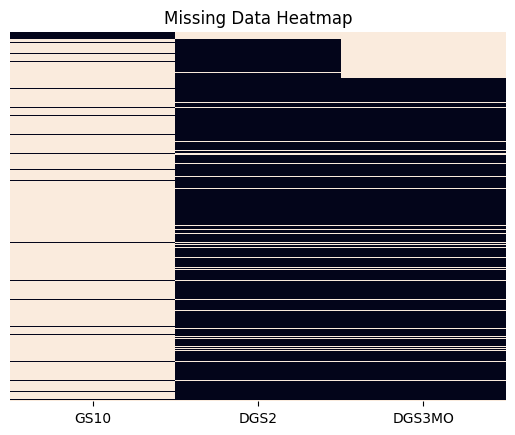

In [8]:
# Check for missing data
print(f"Number of Entries: {len(df_raw)}")

for key, item in df_raw.isnull().sum().items():
    percent_missing = 100 * item / len(df_raw)
    print(f"Missing entries in {series_codes[key]}: \t {item} \t {percent_missing:.2f}%")

vis_missing_data(df_raw)

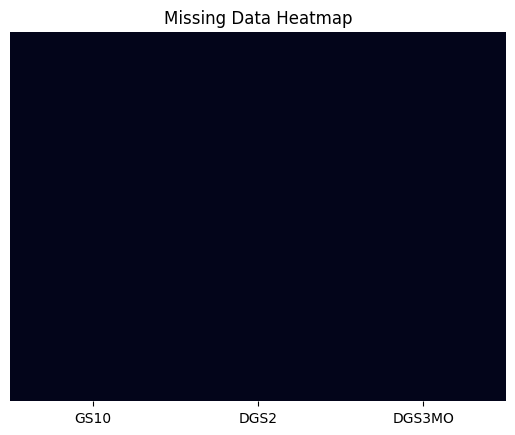

In [9]:
# Missing data would be handled with forward fill and previous entries would be removed
df_clean = df_raw.ffill().dropna()
vis_missing_data(df_clean)

#Export to CSV
output_csv(dataframe=df_clean, 
                   flag = csv_export_config['datasets_cleaned']['save_csv'], 
                   file_name = csv_export_config['datasets_cleaned']['file_title'])
#output_csv(dataframe=df_clean, flag = False, file_name = 'data_clean')

### Feature Engineering

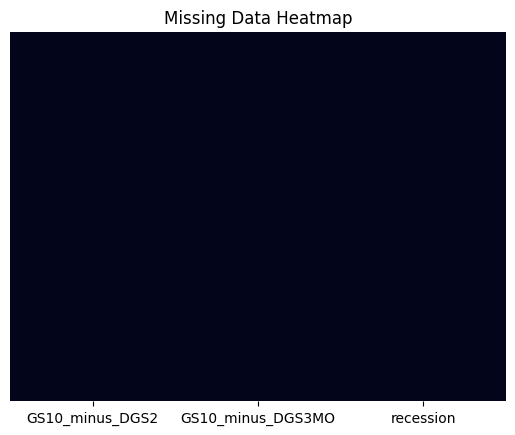

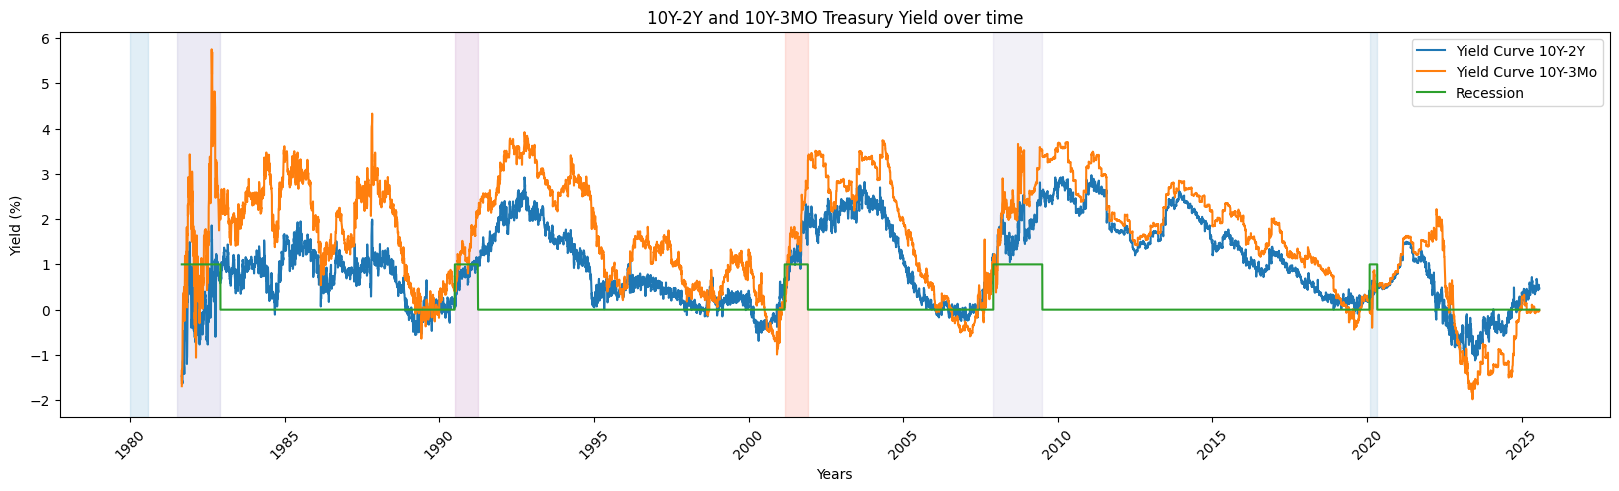

In [10]:
"""We would be creating 3 features
1- GS10 minus DGS2 : GS10_minus_DGS2
2- GS10 minus DGS3MO : GS10_minus_DGS3MO
3- Label Column : recession
"""
df_features = pd.DataFrame()
df_features['GS10_minus_DGS2'] = (df_clean['GS10'] - df_clean['DGS2']).round(4)
df_features['GS10_minus_DGS3MO'] = (df_clean['GS10'] - df_clean['DGS3MO']).round(4)

series_codes.update({'GS10_minus_DGS2': 'Yield Curve 10Y-2Y',
                     'GS10_minus_DGS3MO': 'Yield Curve 10Y-3Mo',
                     'recession': 'Recession'})

#df_list_of_recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv")
df_list_of_recessions = pd.read_csv(f"{notebook_dir}/Dataset/recession_periods.csv")
df_features['recession'] = 0
for row in df_list_of_recessions.itertuples(index=False):
    mask = (df_features.index >= pd.to_datetime(row.start)) & \
           (df_features.index <= pd.to_datetime(row.end))
    df_features.loc[mask, 'recession'] = 1


#Export to CSV
output_csv(dataframe=df_features, 
                   flag = csv_export_config['datasets_features']['save_csv'], 
                   file_name = csv_export_config['datasets_features']['file_title'])

vis_missing_data(df_features)
_, fig = line_plot(dataframe = df_features, labels = series_codes, 
                            plot_title="10Y-2Y and 10Y-3MO Treasury Yield over time" , 
                            df_recessions = df_list_of_recessions)
output_png(fig=fig, flag = png_export_config['png_features']['save_png'], 
                   file_name = png_export_config['png_features']['file_title'])

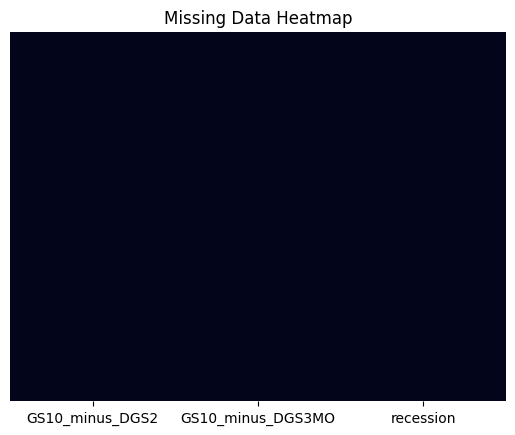

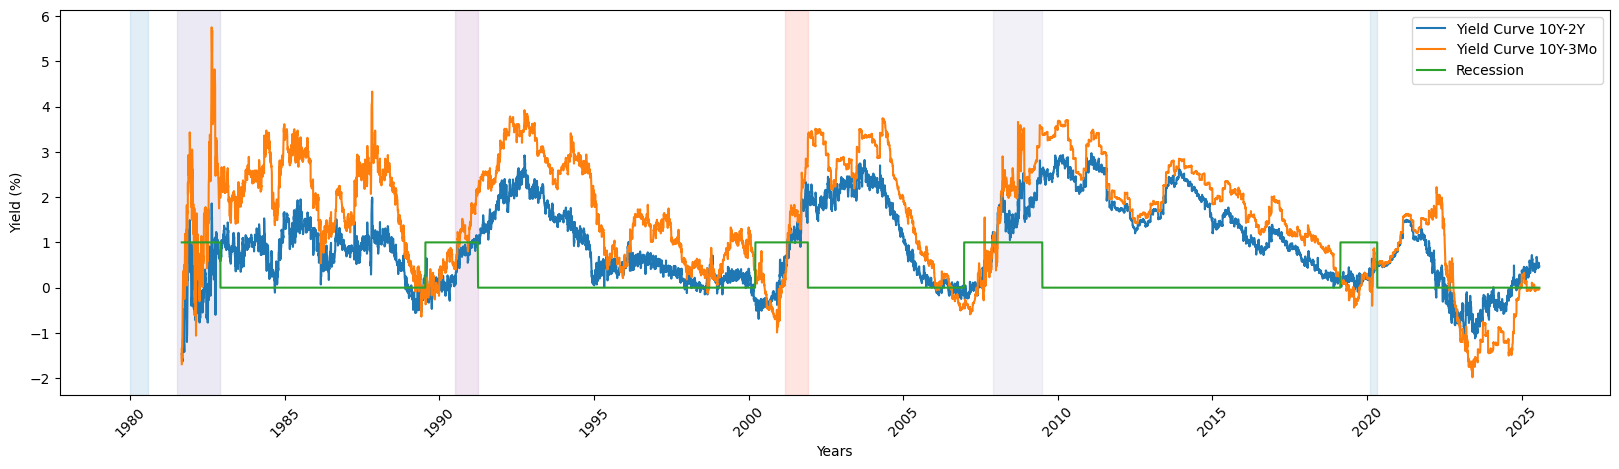

In [11]:
# forward-looking window featrue engineering
df_features.rename(columns={'recession': 'recession_'}, inplace=True)


recession_dates = df_features['recession_'].values
horizon = 252 #~1 year of trading days
future_recession = np.zeros_like(recession_dates)
for i in range(len(recession_dates)):
    if 1 in recession_dates[i:i+horizon]:
        future_recession[i] = 1

df_features['recession'] = future_recession
del df_features['recession_']

vis_missing_data(df_features)

_, fig = line_plot(dataframe = df_features, labels = series_codes, plot_title='', df_recessions = df_list_of_recessions)

In [12]:
# Create 2 extra versions of df_features  

# Daily
df_features_daily = df_features.copy()

# WEEKLY AVERAGES (label at mid‑month)
df_features_weekly = (df_features.resample('W-FRI').mean()).round(4)
df_features_weekly.index = df_features_weekly.index - pd.offsets.Day(2)

# MONTHLY AVERAGES (label at mid‑month)
df_features_monthly = (df_features.resample('ME').mean()).round(4)
df_features_monthly.index = df_features_monthly.index - pd.offsets.DateOffset(days=14)

dict_features = {'Daily': df_features_daily,
                 'Weekly': df_features_weekly,
                 'Monthly': df_features_monthly
}

#Export to CSV
for name, df in dict_features.items():
    output_csv(dataframe=df, 
                   flag = csv_export_config['datasets_features']['save_csv'], 
                   file_name = f'{csv_export_config['datasets_features']['file_title']}_{name.lower()}')

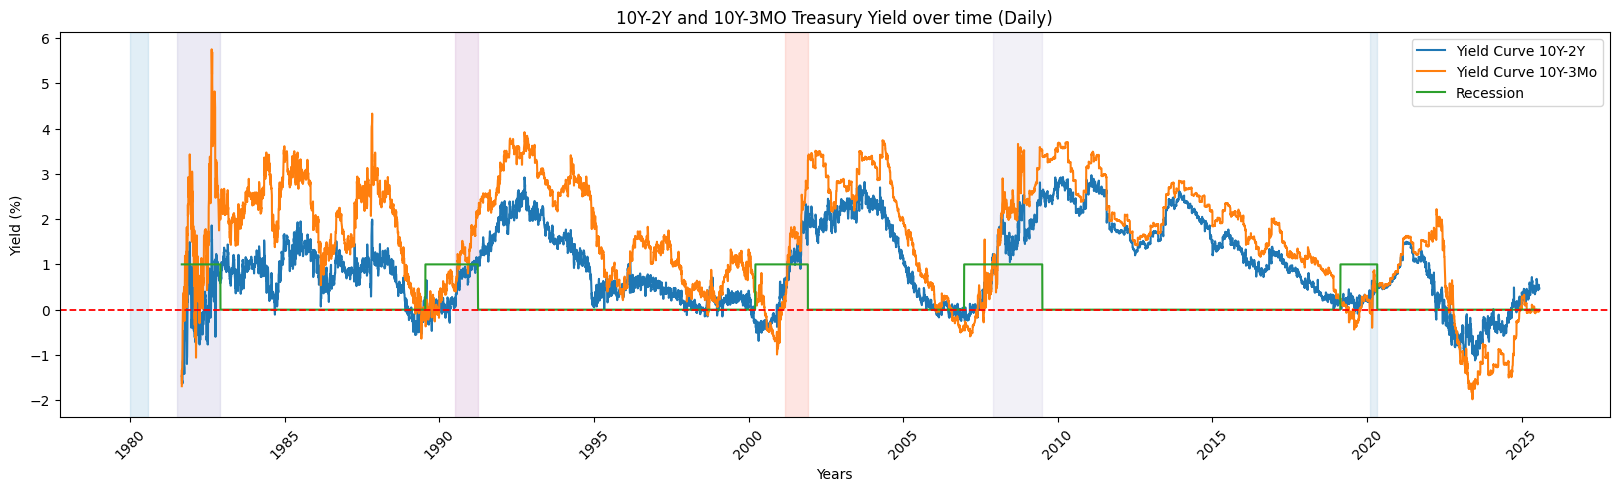

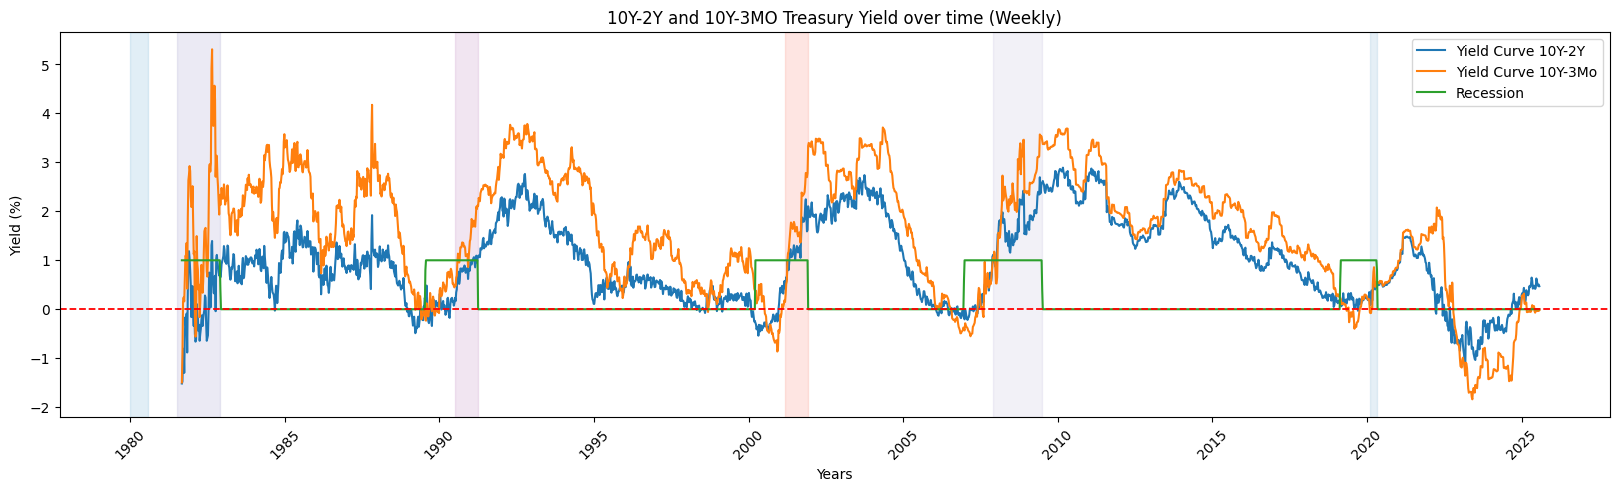

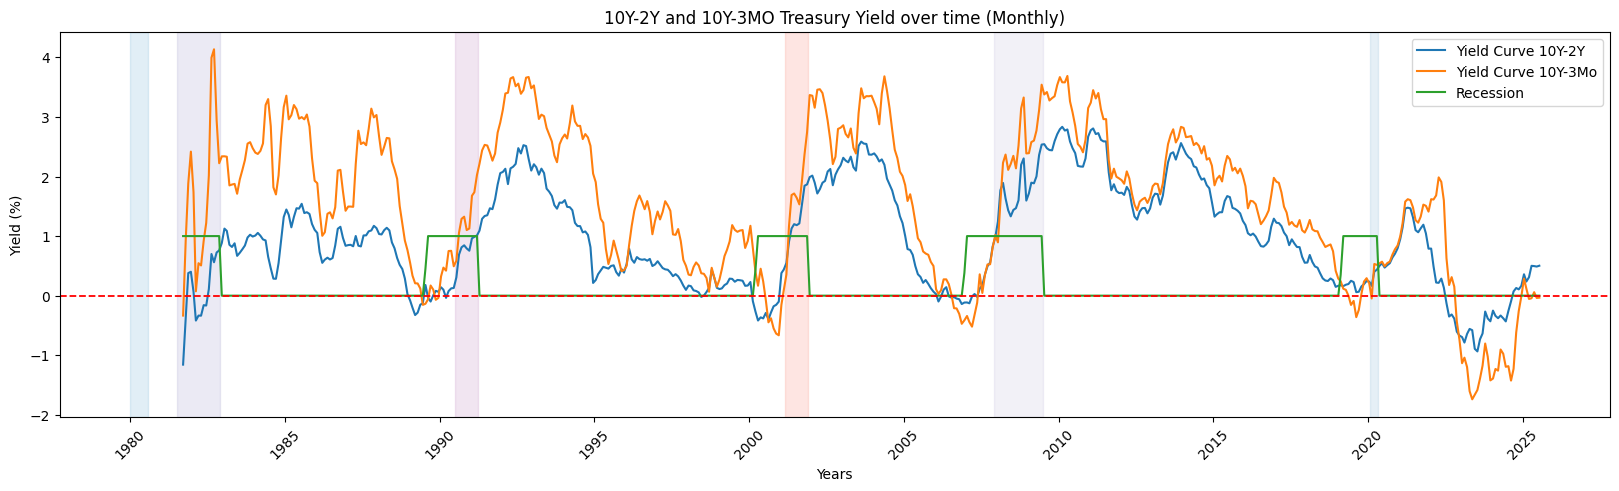

In [13]:
for name, df in dict_features.items():
    name1 = "10Y-2Y and 10Y-3MO Treasury Yield over time"
    full_name = f"{name1} ({name})"
    _, fig = line_plot(df, series_codes, plot_title=full_name, hlines={0: 'red'}, df_recessions = df_list_of_recessions)

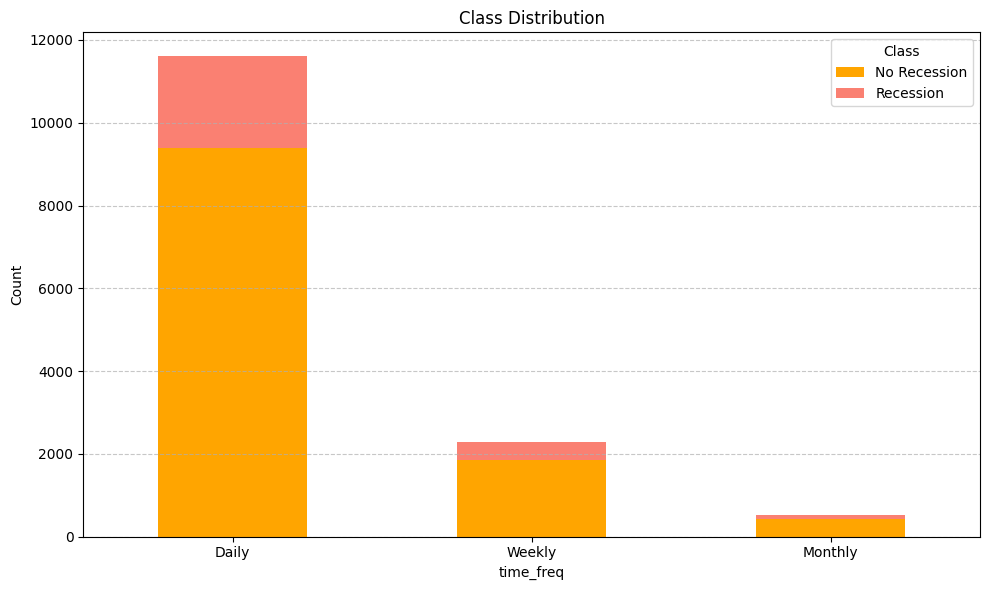

In [14]:
counts = []

for name, df in dict_features.items():
    count_0 = (df['recession'] == 0).sum()
    count_1 = (df['recession'] == 1).sum()
    counts.append({'time_freq': name, 'No Recession': count_0, 'Recession': count_1})

# Convert to DataFrame
count_df = pd.DataFrame(counts)
count_df.set_index('time_freq', inplace=True)

# Plot
count_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['orange', 'salmon'])
plt.title("Class Distribution")
#plt.xlabel("Time Frequency")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Class')

output_png(fig=plt, flag = png_export_config['png_class_imbalance']['save_png'], 
                   file_name = png_export_config['png_class_imbalance']['file_title'])

plt.show()



# Traditional Models

### Required Functions and setup for Traditional Models

In [15]:
#File imports and initialization
#classifier_models = ['logistic', 'xgb', 'balanced_rf', 'easy_ensemble', 'rf']

file_path = f"{notebook_dir}/Dataset/data_features"

df_features_daily = input_csv(f"{file_path}_daily")
df_features_weekly = input_csv(f"{file_path}_weekly")
df_features_monthly = input_csv(f"{file_path}_monthly")

#recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv")
#recessions = input_csv(f"{project_dir}/Dataset/recession_periods")
#recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv1")

dict_features = {'Daily': df_features_daily,
                 'Weekly': df_features_weekly,
                 'Monthly': df_features_monthly
} 

train_test_split = pd.to_datetime('2015-01-01')
split_at = train_test_split

export_config = {'Print Out For all models': 
                  {'show': False},
                 'Save Probability Plots as PNG': 
                  {'save': False},
                 'Export AUC Report to CSV': 
                  {'save': False},
                 'Print Out For performant models': 
                  {'show': True}
                  
}


DataFrame loaded from c:\Users\fejio\Monroe University\Yu-Jiun Chen - Machine Learning Final Group Project\Final Submission/Dataset/data_features_daily.csv
DataFrame loaded from c:\Users\fejio\Monroe University\Yu-Jiun Chen - Machine Learning Final Group Project\Final Submission/Dataset/data_features_weekly.csv
DataFrame loaded from c:\Users\fejio\Monroe University\Yu-Jiun Chen - Machine Learning Final Group Project\Final Submission/Dataset/data_features_monthly.csv


In [16]:

def trad_model_init(train,test,model):
    '''
    Model Initialization function
    '''
    X_train, y_train = train[0], train[1]
    X_test, y_test = test[0], test[1]

    steps = [
        ('scaler', StandardScaler()),
        ('over', SMOTE(random_state=42, sampling_strategy= 0.5)),
        ('under', RandomUnderSampler(random_state=42, sampling_strategy=1.0))
    ]

    steps1 = [('scaler', StandardScaler())]
    model_name = str(model)
    model_name = model_name.split("(")[0].lower()

    if model_name in ['logisticregression', 'xgbclassifier', 'balancedrandomforestclassifier']:
        steps.append(('classifier', model))
        pipeline = Pipeline(steps=steps)
    else:
        steps1.append(('classifier', model))
        pipeline = Pipeline(steps=steps1)

    pipeline.fit(X_train, y_train)
    #probs = pipeline.predict_proba(X_test))[:, 1]
    X_all = pd.concat([X_train, X_test])
    probs = pipeline.predict_proba(X_all)[:, 1]
    dates_all = pd.to_datetime(X_all.index)
    prob_series = pd.Series(probs, index=dates_all)

    return pipeline, prob_series

def trad_model_metrics(test, probs, threshold = None):
    '''
    Model Finalizing function
    '''
    X_test, y_test = test[0], test[1]
    #probs = pipeline.predict_proba(X_test)[:, 1]
    #probs
    if threshold is None:
        threshold = 0.001
    y_pred = (probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    #cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["No Recession", "Recession"], output_dict=True, zero_division=0)
    report["auc_pr"] = auc(recall, precision)
    #report["ap_score"]=  average_precision_score(y_test, probs)
    #report["auc_roc"]= roc_auc_score(y_test, probs)

    ap_score = average_precision_score(y_test, probs)
    report["ap_score"]=  ap_score
    report["ap_score_inverted"] = 1-ap_score
    report["auc_roc"]= roc_auc_score(y_test, probs)
    report["log_loss"] = log_loss(y_test, probs)
    report["brier_score_loss"] = brier_score_loss(y_test, probs)

    return report



### Initializing and Training of models

In [17]:
# Models of choice 
def xgb_init(y_train):
    num_pos = sum(y_train == 1)
    num_neg = sum(y_train == 0)
    scale = num_neg / num_pos
    #print(scale)
    model = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale)
    return model


dict_classifier_models = {'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
                          'xgb': lambda y: xgb_init(y), 
                          'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_estimators=200, random_state=42), 
                          'EasyEnsembleClassifier': EasyEnsembleClassifier(n_estimators=200, random_state=42), 
                          'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', criterion='log_loss', random_state=42, n_estimators=200)
}

In [18]:
#Initialize models
#Get pipleines and probability values
classifier_results = {}

for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession'] 

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)

    classifier_results[time_freq] = {}
    for model_name, model in dict_classifier_models.items():
        classifier_results[time_freq][model_name] = {}

        if callable(model):
            model_instance = model(y_train)
        else:
            model_instance = model

        pipeline, probs = trad_model_init([X_train, y_train],[X_test, y_test], model_instance)
        classifier_results[time_freq][model_name]['pipeline'] = pipeline 
        classifier_results[time_freq][model_name]['probs'] = probs 
 

In [19]:
# Get metrics and report from model pipelines

for time_freq, model_details in classifier_results.items():

    df = dict_features[time_freq]
    X = df.drop(columns='recession')
    y = df['recession']

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_test = X[X.index >= split_at]
    y_test = y[y.index >= split_at].astype(int)


    for model_name in dict_classifier_models.keys():
        probs = classifier_results[time_freq][model_name]['probs']
        report = trad_model_metrics(probs = probs[split_at:], test = [X_test, y_test], threshold = None)
        classifier_results[time_freq][model_name]['report'] = report
        #print(model_name)
        #print(df)
        

In [20]:

# Print out for all Reports
if export_config['Print Out For all models']['show']:
    for time_freq in classifier_results.keys():
        for model_name in classifier_results[time_freq].keys():
            print(f"\n=== {time_freq} | {model_name} ===")
            #print("Confusion Matrix:\n", classifier_results[time_freq][f'{model_name}_confusion_matrix'])
            print("Classification Report:")
            print(pd.DataFrame(classifier_results[time_freq][model_name]['report']).transpose())



### Metrics Assessment

In [21]:
# Removing underperforming models based on AUC-ROC scores
# Only models with AUC-ROC >= 0.5 are retained
# AUC-ROC of 0.5 represents random guessing, so anything below that is worse than chance

import copy

classifier_results_selective = copy.deepcopy(classifier_results)
keys = list(classifier_results_selective.keys())
for time_freq in list(classifier_results_selective.keys()):
    for model_name in list(classifier_results_selective[time_freq].keys()):
        if classifier_results_selective[time_freq][model_name]['report']['auc_roc'] < 0.5:
            del classifier_results_selective[time_freq][model_name]


# Print out for performant Reports
if export_config['Print Out For performant models']['show']:
    for time_freq in classifier_results_selective.keys():
        for model_name in classifier_results_selective[time_freq].keys():
            print(f"\n=== {time_freq} | {model_name} ===")
            #print("Confusion Matrix:\n", classifier_results_selective[time_freq][f'{model_name}_confusion_matrix'])
            print("Classification Report:")
            print(pd.DataFrame(classifier_results_selective[time_freq][model_name]['report']).transpose())




=== Daily | LogisticRegression ===
Classification Report:
                   precision    recall  f1-score      support
No Recession        0.000000  0.000000  0.000000  2471.000000
Recession           0.113702  1.000000  0.204187   317.000000
accuracy            0.113702  0.113702  0.113702     0.113702
macro avg           0.056851  0.500000  0.102093  2788.000000
weighted avg        0.012928  0.113702  0.023216  2788.000000
auc_pr              0.171312  0.171312  0.171312     0.171312
ap_score            0.172000  0.172000  0.172000     0.172000
ap_score_inverted   0.828000  0.828000  0.828000     0.828000
auc_roc             0.722159  0.722159  0.722159     0.722159
log_loss            1.006893  1.006893  1.006893     1.006893
brier_score_loss    0.375434  0.375434  0.375434     0.375434

=== Daily | EasyEnsembleClassifier ===
Classification Report:
                   precision    recall  f1-score      support
No Recession        0.000000  0.000000  0.000000  2471.000000
Recession 

### Visualizing Model outcome Using Predicted Probabilities

<>:21: SyntaxWarning: invalid escape sequence '\T'
<>:21: SyntaxWarning: invalid escape sequence '\T'
C:\Users\fejio\AppData\Local\Temp\ipykernel_16432\2563510402.py:21: SyntaxWarning: invalid escape sequence '\T'
  plt.axvline(x=train_test_split, label='Train\Test Split', color='gray', linestyle='--')


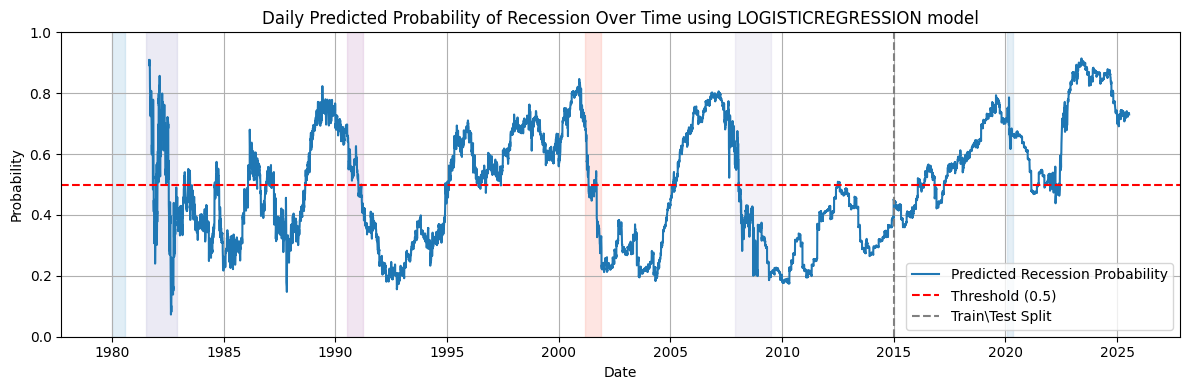

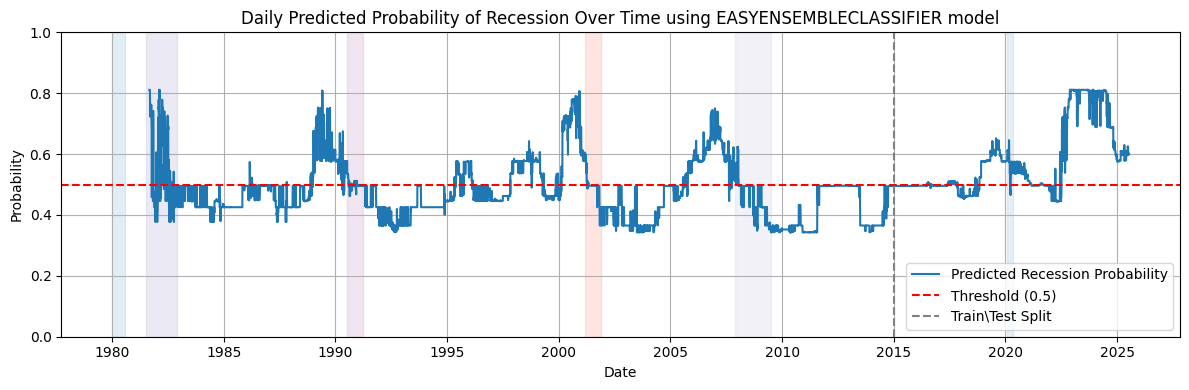

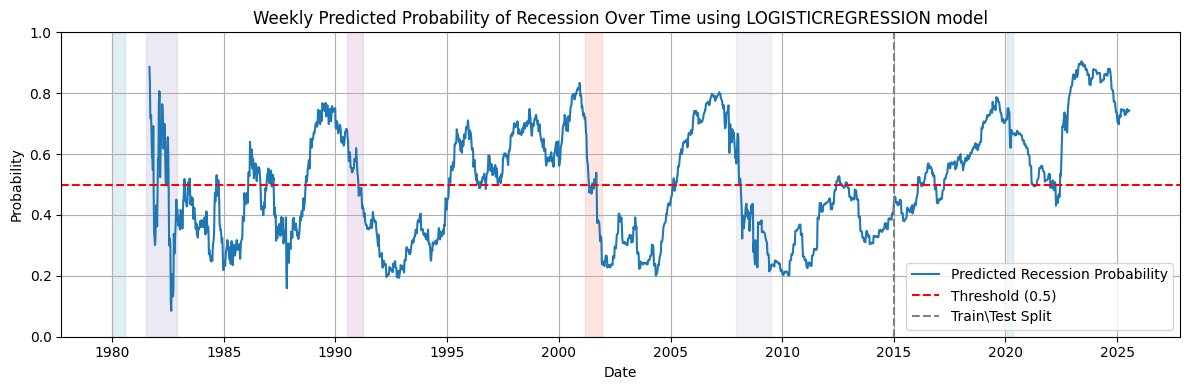

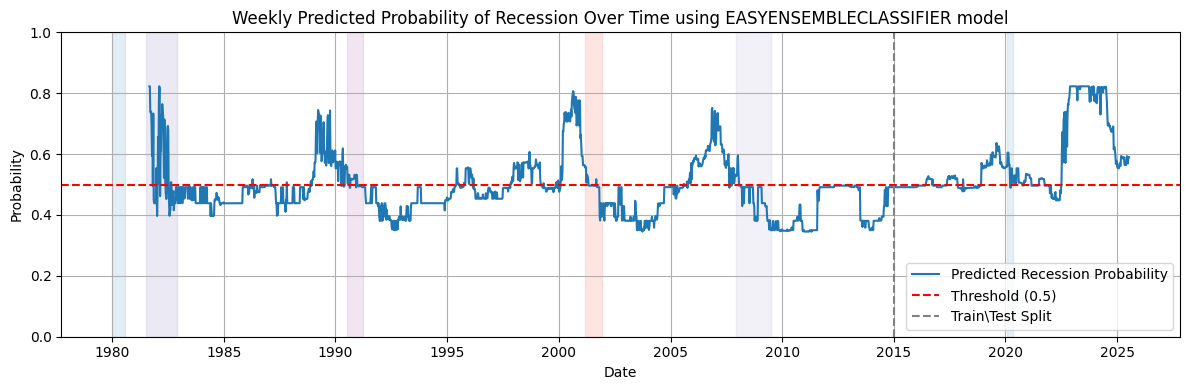

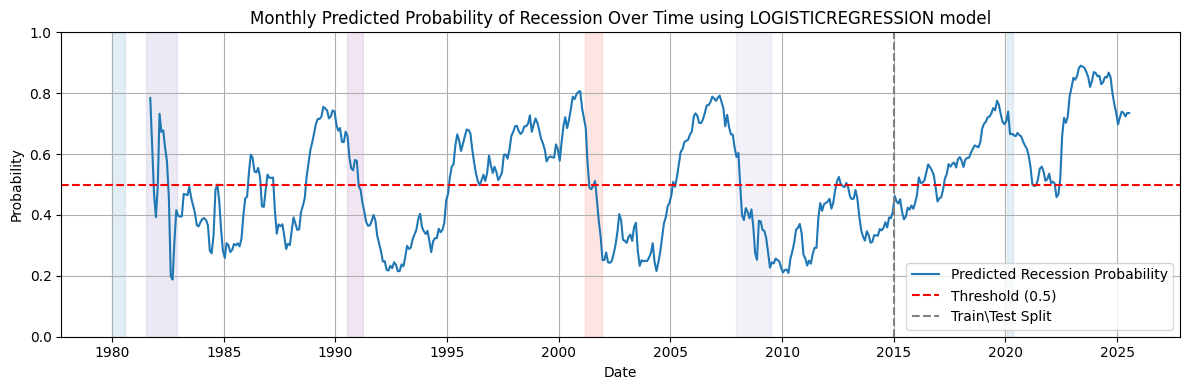

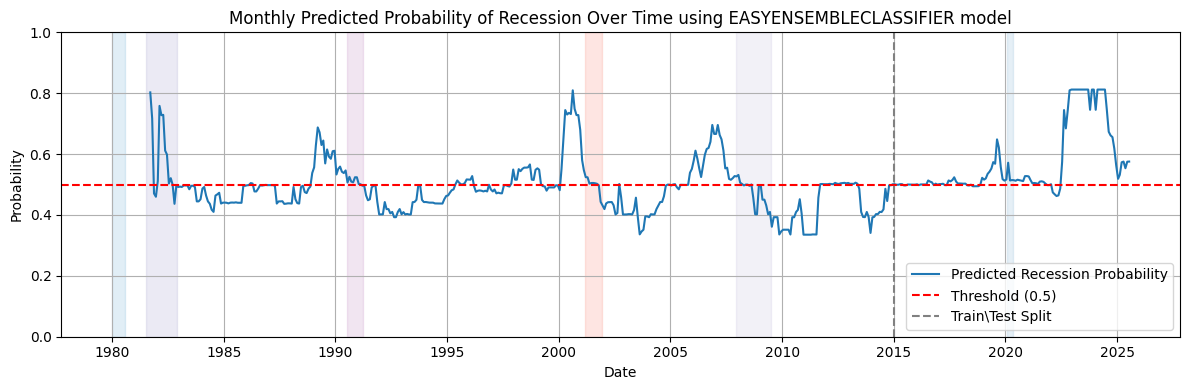

In [22]:

for time_freq, df in dict_features.items():
    #print(time_freq)
    X = df.drop(columns='recession')
    y = df['recession']
    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at], y[y.index >= split_at]
    for model_name in classifier_results_selective[time_freq].keys():
        prob_series = classifier_results_selective[time_freq][model_name]['probs']

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(prob_series, label='Predicted Recession Probability')
        #if model_name in ['logistic']:
        #    plt.axhline(y=0.4, color='r', linestyle='--', label='Threshold (0.4)')
        #elif model_name in ['balanced_rf','rf']:
        #    plt.axhline(y=0.85, color='r', linestyle='--', label='Threshold (0.8)')
        #else:
        plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
        plt.axvline(x=train_test_split, label='Train\Test Split', color='gray', linestyle='--')
#
        if df_list_of_recessions is not None:
            for row in df_list_of_recessions.itertuples(index=False):
                #print(row)
                plt.axvspan(pd.to_datetime(row.start), pd.to_datetime(row.end), color=row.color, alpha=0.2)

        file_name = f'{time_freq} Predicted Probability of Recession Over Time using {model_name.upper()} model'
        plt.title(file_name)
        plt.xlabel('Date')
        plt.ylabel('Probability')
        #handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend()#handles[:2], labels[:2], loc = 'upper left')
        plt.ylim(0, 1)
        plt.grid(True)
        plt.tight_layout()

        output_png(plt, file_name = file_name, 
                            flag = export_config['Save Probability Plots as PNG']['save'])

        plt.show()

In [23]:
# Data Collection to analyze in report

if export_config['Export AUC Report to CSV']['save']:
    from datetime import datetime
    import pytz
    import csv

    tz = pytz.timezone('US/Eastern')
    eastern_time = datetime.now(tz)
    eastern_time = eastern_time.strftime("%Y-%m-%d %H;%M;%S")
    rows = []

    for time_freq in list(classifier_results.keys()):
        for model_name in list(classifier_results[time_freq].keys()):
            auc_roc = classifier_results[time_freq][model_name]['report']['auc_roc']
            #print(auc_roc)
            rows.append([time_freq, model_name, auc_roc.round(4)])

    # Save to CSV
    with open(f"{notebook_dir}/Dataset/auc_roc_summary_{eastern_time}.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['time_freq', 'model_name', 'auc_roc'])  # header
        writer.writerows(rows)


# LSTM Models

### Required Functions and setup for LSTM Models

In [ ]:
#File imports and initialization
file_path = f"{notebook_dir}/Dataset/data_features"
#file_path_0 = f"{project_dir}/Dataset/data_features"
#file_path_1 = f"{project_dir}/Dataset/"

df_features_daily = input_csv(f"{file_path}_daily")
df_features_weekly = input_csv(f"{file_path}_weekly")
df_features_monthly = input_csv(f"{file_path}_monthly")

#recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv")
#recessions = input_csv(f"{project_dir}/Dataset/recession_periods")
#recessions = pd.read_csv(f"{project_dir}/Dataset/recession_periods.csv1")

dict_features = {'Daily': df_features_daily,
                 'Weekly': df_features_weekly,
                 'Monthly': df_features_monthly
} 

train_test_split = pd.to_datetime('2015-01-01')
split_at = train_test_split
split_at_num = mdates.date2num(split_at)

export_config = {'Print Out For all models': 
                  {'print': True},
                 'Save Probability Plots as PNG': 
                  {'save': False},
                 'Export AUC Report to CSV': 
                  {'save': False},
                 'All or Test dataset for plots': 
                  {'print': True},
}



DataFrame loaded from c:\Users\fejio\Monroe University\Yu-Jiun Chen - Machine Learning Final Group Project\Final Submission/Dataset/data_features_daily.csv
DataFrame loaded from c:\Users\fejio\Monroe University\Yu-Jiun Chen - Machine Learning Final Group Project\Final Submission/Dataset/data_features_weekly.csv
DataFrame loaded from c:\Users\fejio\Monroe University\Yu-Jiun Chen - Machine Learning Final Group Project\Final Submission/Dataset/data_features_monthly.csv


In [38]:
# Required Functions
# Refactor
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        
        cross_entropy = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)

        loss = alpha_factor * modulating_factor * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss

def make_sequences(X, y=None, seq_len=12):
    X_seq, y_seq, timestamps = [], [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X.iloc[i:i+seq_len].values)
        timestamps.append(X.index[i+seq_len])
        #print(timestamps)
        if y is not None:
            y_seq.append(y.iloc[i+seq_len])

    X_seq = np.array(X_seq)
    return (X_seq, np.array(y_seq)) if y is not None else (X_seq, None)


def get_class_weight(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    alpha = class_weights[1] / (class_weights[0] + class_weights[1])
    return class_weights_dict, alpha
    
    
def scaling_features(train,test, scaler_func = StandardScaler()):
    scaler = scaler_func
    X_train = train
    X_test = test
    n_train, seq_len, n_feat = X_train.shape
    n_test,      _   ,  _    = X_test.shape
    if scaler_func is None:
        return X_train, X_test, seq_len, n_feat

    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_feat)).reshape(n_train, seq_len, n_feat)
    X_test_scaled  = scaler.transform    (X_test.reshape(-1, n_feat)).reshape(n_test, seq_len, n_feat)

    return X_train_scaled, X_test_scaled, seq_len, n_feat, scaler



def layer_sizes(str_var):
    #str_var = 'LSTM_4_2'
    parts = str_var.split('_')
    int_list = [int(x) for x in parts[1:]]
    model_type = parts[0]
    return int_list, model_type
    

In [39]:
# Derivative Functions for Model setup
def LSTM_Model_init(model_name, seq_len, n_feat, alpha):

    layer_size, model_type = layer_sizes(model_name)

    is_bi = model_type.upper().startswith("BILSTM")

    #Build model
    model = Sequential()
    model.add(Input(shape=(seq_len, n_feat)))
    

    for i, units in enumerate(layer_size):
        return_seq = (i < len(layer_size) - 1)
        lstm_layer = LSTM(units, return_sequences=return_seq)

        if is_bi:
            # wrap in Bidirectional
            model.add(Bidirectional(lstm_layer))
        else:
            model.add(lstm_layer)
        
        model.add(Dropout(0.3))
    # stuff
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss=binary_focal_loss(gamma=2.0, alpha=alpha),
        #metrics=["accuracy"]
        metrics=[#"Precision", "Recall", #"AUC"]
                    AUC(name='AUC-ROC', curve = 'ROC'),
                    AUC(name='AUC-PR', curve='PR')]
    )

    return model

#early_stop = EarlyStopping(monitor="val_Recall", patience=10, restore_best_weights=True, mode='max')

def LSTM_Model_train(train, test, early_stop, model, class_weights, verbose = 0):
    X_train_scaled, y_train = train[0], train[1]
    X_test_scaled, y_test = test[0], test[1]
    callback_list = [early_stop] if early_stop is not None else []
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50, batch_size=32, #change to 30
        callbacks=callback_list,
        class_weight=class_weights,
        verbose=verbose#, shuffle = False
    )

    #X_all_scaled = np.concatenate([X_train_scaled, X_test_scaled], axis=0) #pd.concat([X_train_scaled, X_test_scaled])
    #probs_all = model.predict(X_all_scaled, verbose=verbose).reshape(-1)
    epochs = len(history.history['loss'])

    probs = model.predict(X_test_scaled, verbose=verbose).reshape(-1)
    probs_all = probs
    return model, epochs, probs_all

def LSTM_Model_evaluate(test, probs, threshold = None):
    X_test_scaled, y_test = test[0], test[1]
    if threshold is None:
        threshold = 0.001
    y_pred = (probs >= threshold).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    #cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["No Recession", "Recession"], output_dict=True, zero_division=0)
    report["auc_pr"] = auc(recall, precision)
    ap_score = average_precision_score(y_test, probs)
    report["ap_score"]=  ap_score
    report["ap_score_inverted"] = 1-ap_score
    report["auc_roc"]= roc_auc_score(y_test, probs)
    report["log_loss"] = log_loss(y_test, probs)
    report["brier_score_loss"] = brier_score_loss(y_test, probs)


    #epochs = len(history.history['loss'])
    return report




### Initializing and Training of LSTM models

In [40]:
LSTM_models = []
#LSTM_models.extend(['LSTM_2'])
LSTM_models.extend(['LSTM_4', 'LSTM_8'])
LSTM_models.extend(['LSTM_4_4', 'LSTM_8_4', 'LSTM_8_8'])
#LSTM_models.extend(['BiLSTM_4', 'BiLSTM_8', 'BiLSTM_4_4', 'BiLSTM_8_4', 'BiLSTM_8_8'])
print(LSTM_models)
LSTM_results = {}
early_stop = EarlyStopping(monitor="val_AUC-ROC", patience=10, restore_best_weights=True, mode='max')

['LSTM_4', 'LSTM_8', 'LSTM_4_4', 'LSTM_8_4', 'LSTM_8_8']


In [42]:
for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession'] 

    # Train-test split
    #split_at = pd.to_datetime('2015-01-01')
    X_train, X_test = X[X.index < split_at], X[X.index >= split_at]
    y_train, y_test = y[y.index < split_at].astype(int), y[y.index >= split_at].astype(int)

    # Convert to sequences
    seq_len = 32
    X_train_seq, y_train_seq = make_sequences(X_train, y_train, seq_len)
    X_test_seq, y_test_seq = make_sequences(X_test, y_test, seq_len)

    X_train_scaled, X_test_scaled, _, n_feat, scaler = scaling_features(X_train_seq, X_test_seq) #one time calculation per time_freq?
    class_weights_dict, alpha = get_class_weight(y_train_seq) # one time calculation per time_freq?

    LSTM_results[time_freq] = {}
    for model_name in LSTM_models:
        LSTM_results[time_freq][model_name] = {}
        #print(model_name)
        #tf.keras.utils.set_random_seed(seed)
        model_init = LSTM_Model_init(model_name, seq_len, n_feat, alpha)
        #print('Done with Init')
        model, epoch, probs = LSTM_Model_train(train = [X_train_scaled,y_train_seq], test = [X_test_scaled, y_test_seq], 
                         model = model_init, early_stop = early_stop, class_weights = class_weights_dict, 
                         verbose = 0)
        print(f'Done with training {model_name} with {epoch} epochs on {time_freq} data')
        report = LSTM_Model_evaluate(test = [_, y_test_seq], probs = probs, threshold = 0.5)  
        
        #LSTM_results[time_freq][model_name]['probs'] = probs_all
        LSTM_results[time_freq][model_name]['scaler'] = scaler
        LSTM_results[time_freq][model_name]['report'] = report
        LSTM_results[time_freq][model_name]['epoch'] = epoch
        LSTM_results[time_freq][model_name]['model'] = model




Done with training LSTM_4 with 11 epochs on Daily data
Done with training LSTM_8 with 14 epochs on Daily data
Done with training LSTM_4_4 with 11 epochs on Daily data
Done with training LSTM_8_4 with 11 epochs on Daily data
Done with training LSTM_8_8 with 11 epochs on Daily data
Done with training LSTM_4 with 20 epochs on Weekly data
Done with training LSTM_8 with 12 epochs on Weekly data
Done with training LSTM_4_4 with 23 epochs on Weekly data
Done with training LSTM_8_4 with 48 epochs on Weekly data
Done with training LSTM_8_8 with 46 epochs on Weekly data
Done with training LSTM_4 with 11 epochs on Monthly data
Done with training LSTM_8 with 50 epochs on Monthly data
Done with training LSTM_4_4 with 42 epochs on Monthly data
Done with training LSTM_8_4 with 26 epochs on Monthly data
Done with training LSTM_8_8 with 21 epochs on Monthly data


### Metrics Assessment

In [43]:
if export_config['Print Out For all models']['print']:
    for time_freq in LSTM_results.keys():
        for model_name in LSTM_results[time_freq].keys():
            print(f"\n=== {time_freq} | {model_name} ===")
            #print("Confusion Matrix:\n", LSTM_results[time_freq][f'{model_name}_confusion_matrix'])
            print("Classification Report:")
            print(pd.DataFrame(LSTM_results[time_freq][model_name]['report']).transpose())


=== Daily | LSTM_4 ===
Classification Report:
                   precision    recall  f1-score      support
No Recession        1.000000  0.243132  0.391161  2439.000000
Recession           0.146556  1.000000  0.255645   317.000000
accuracy            0.330189  0.330189  0.330189     0.330189
macro avg           0.573278  0.621566  0.323403  2756.000000
weighted avg        0.901835  0.330189  0.375574  2756.000000
auc_pr              0.171086  0.171086  0.171086     0.171086
ap_score            0.171642  0.171642  0.171642     0.171642
ap_score_inverted   0.828358  0.828358  0.828358     0.828358
auc_roc             0.719835  0.719835  0.719835     0.719835
log_loss            0.744305  0.744305  0.744305     0.744305
brier_score_loss    0.275367  0.275367  0.275367     0.275367

=== Daily | LSTM_8 ===
Classification Report:
                   precision    recall  f1-score      support
No Recession        1.000000  0.140631  0.246585  2439.000000
Recession           0.131372  1.000000

### Visualizing Model outcome Using Predicted Probabilities

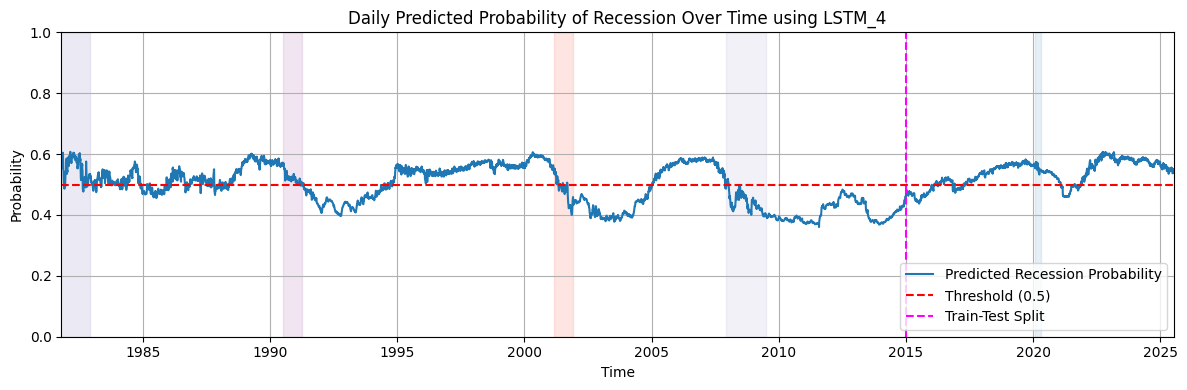

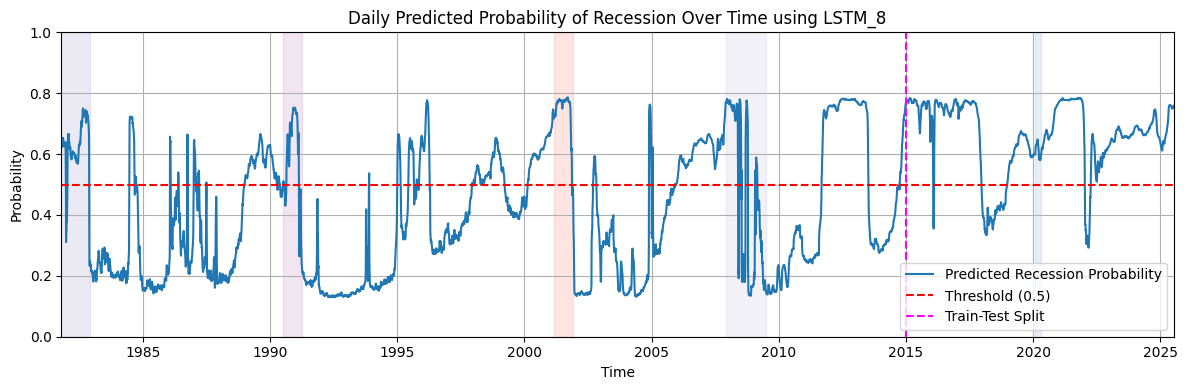

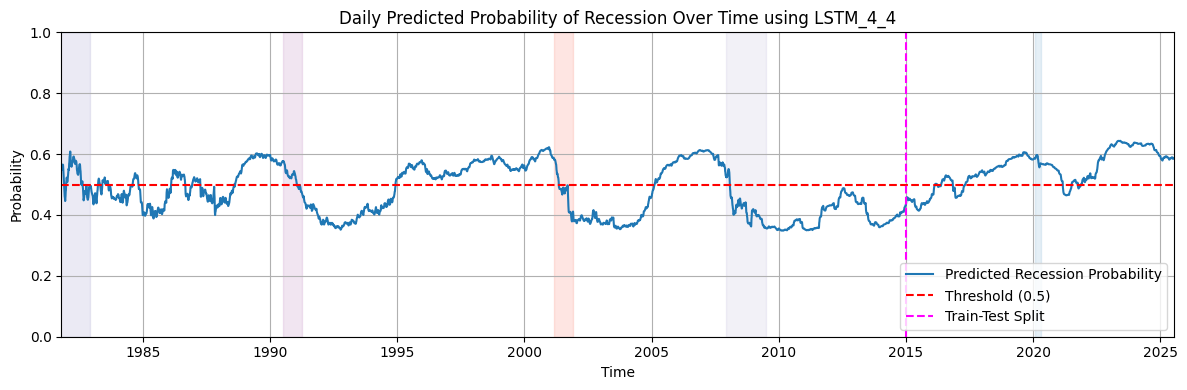

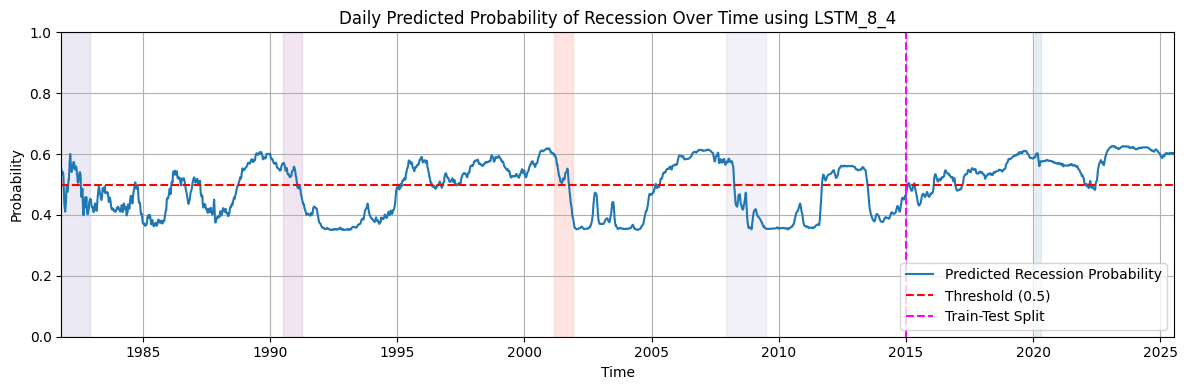

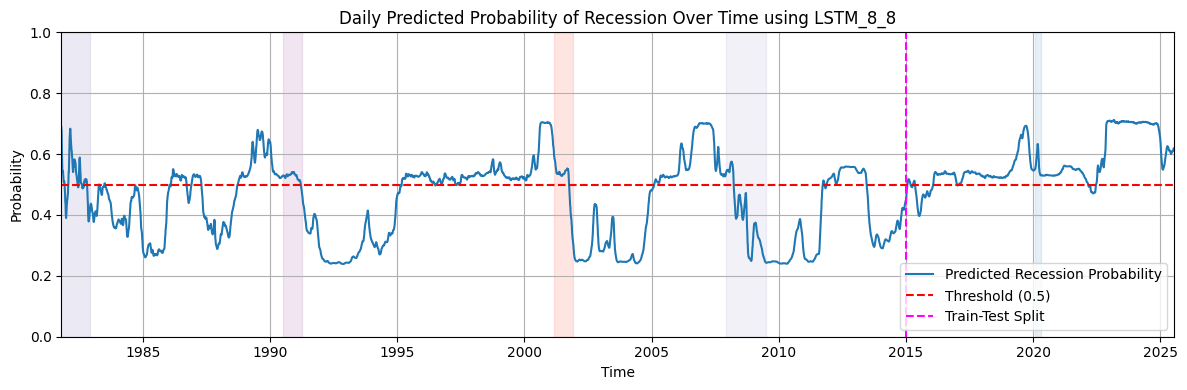

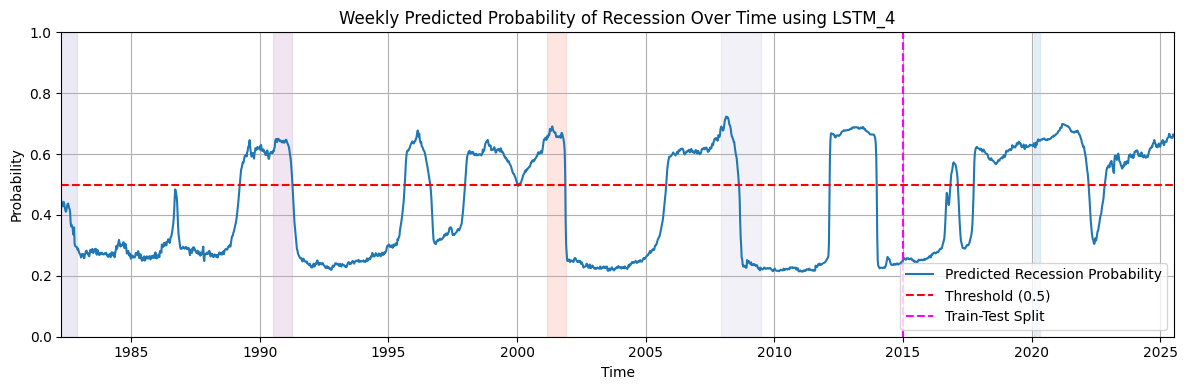

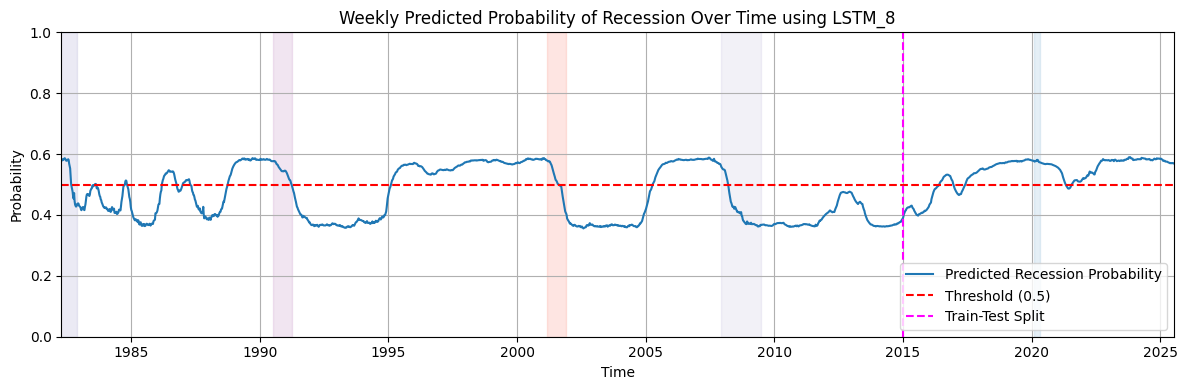

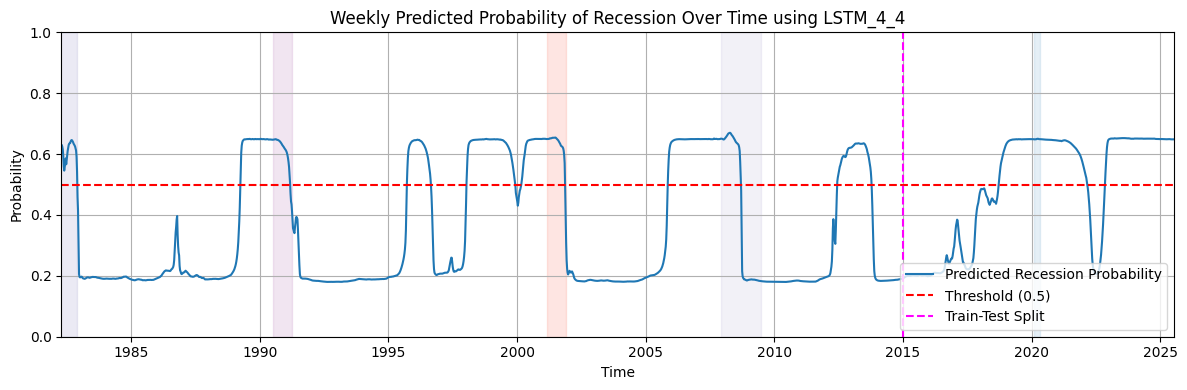

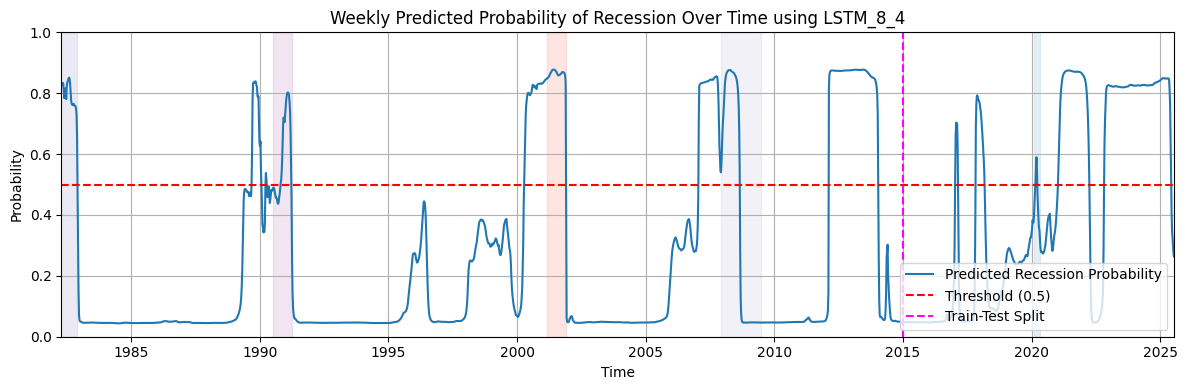

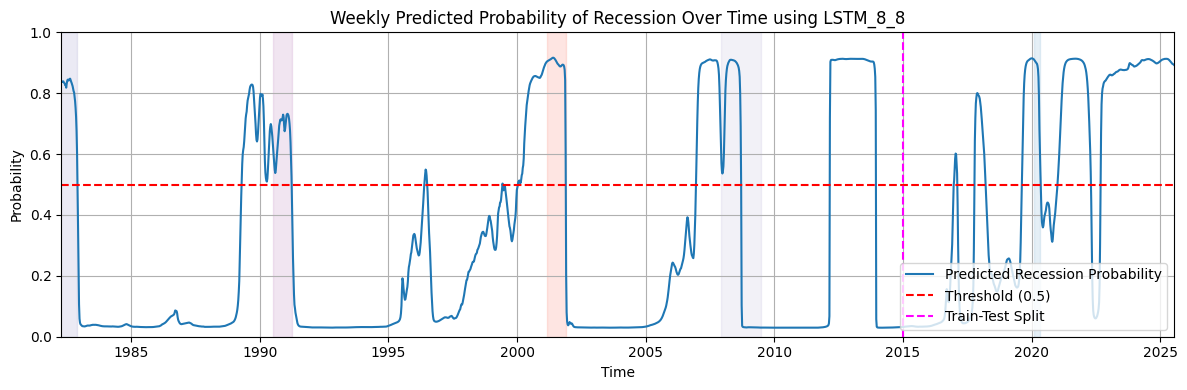

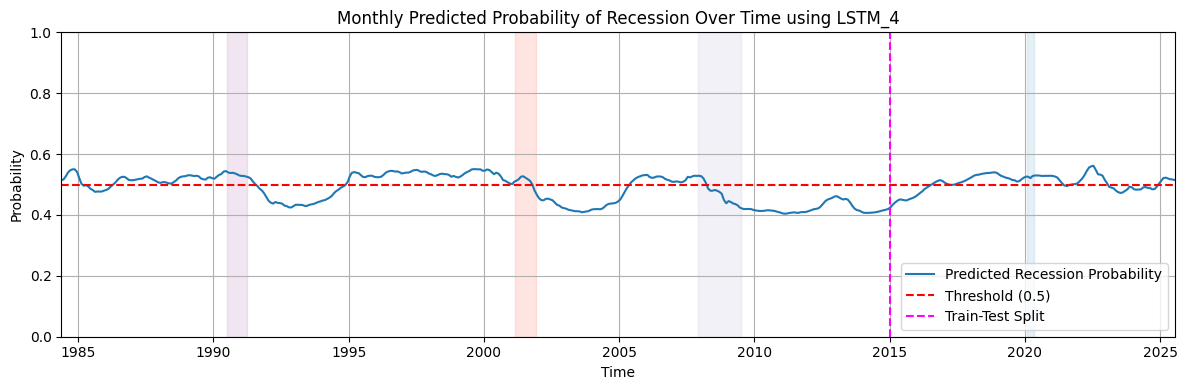

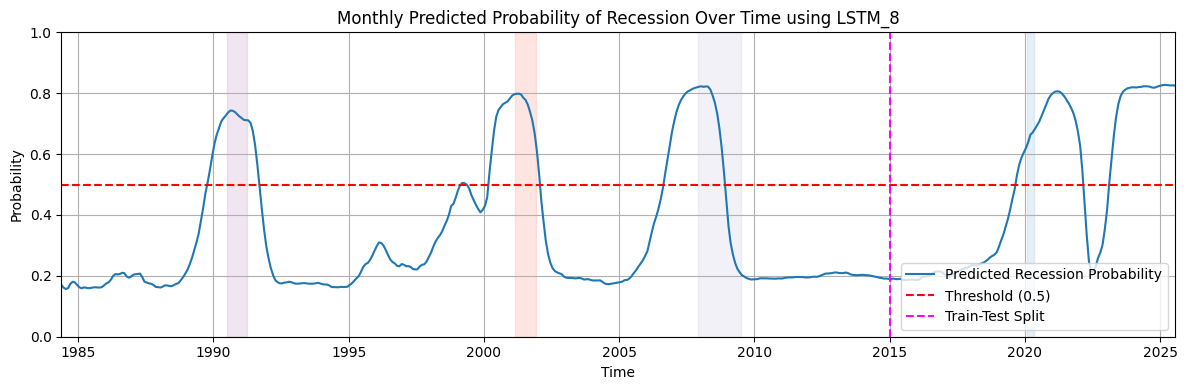

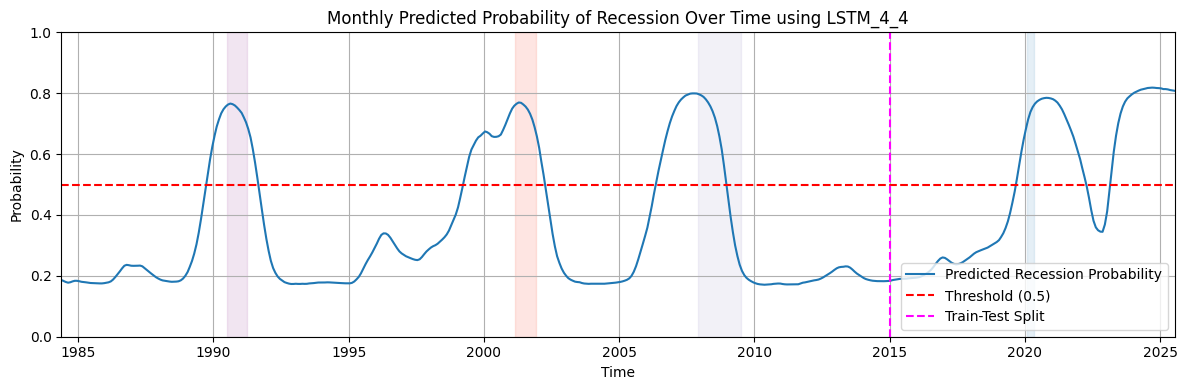

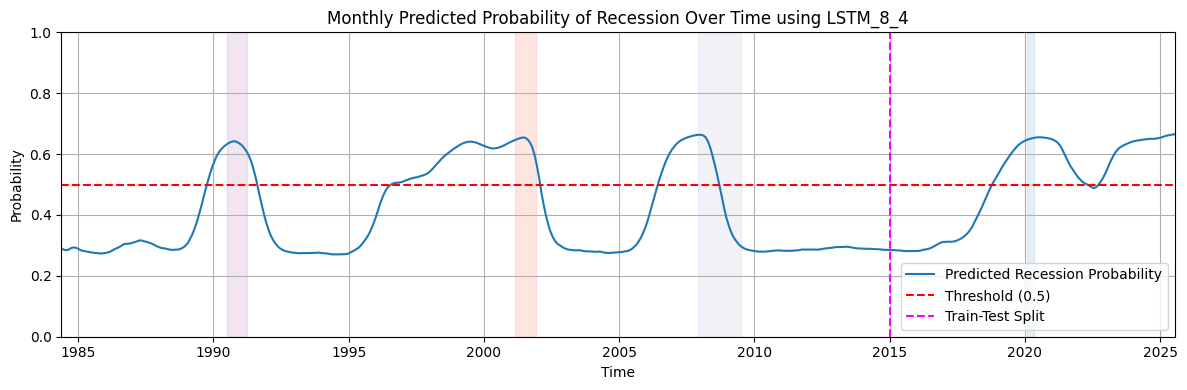

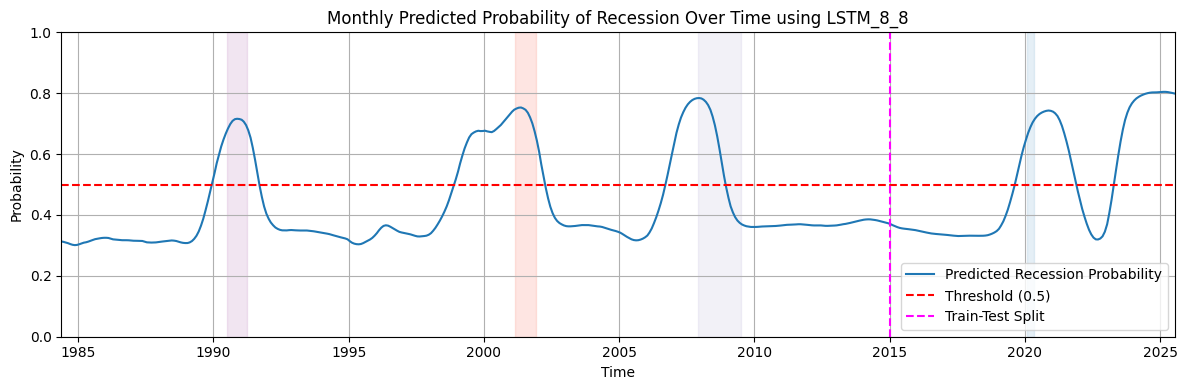

In [44]:
df_list_of_recessions['start'] = pd.to_datetime(df_list_of_recessions['start'])
df_list_of_recessions['end']   = pd.to_datetime(df_list_of_recessions['end'])

for time_freq, df in dict_features.items():
    X = df.drop(columns='recession')
    y = df['recession']

    X_test = X[X.index >= split_at]
    X_all = X
    
    for model_name in LSTM_models:
        model = LSTM_results[time_freq][model_name]['model']
        scaler = LSTM_results[time_freq][model_name]['scaler']
        
        X_test_seq, _ = make_sequences(X_test, y=None, seq_len=seq_len)
        X_test_scaled = scaler.transform(X_test_seq.reshape(-1, X_test.shape[1])).reshape(X_test_seq.shape)
        X_all_seq, _ = make_sequences(X_all, y=None, seq_len=seq_len)
        X_all_scaled = scaler.transform(X_all_seq.reshape(-1, X_all.shape[1])).reshape(X_all_seq.shape)

        probs_all = model.predict(X_all_scaled, verbose=0)
        dates_all = X_all.index[seq_len:]
        prob_series_all  = pd.Series(probs_all.flatten(), index=dates_all)

        if export_config['All or Test dataset for plots']['print'] == True:
            prob_series = prob_series_all
            recessions_to_plot = df_list_of_recessions.copy()
        else:
            probs_test = model.predict(X_test_scaled, verbose=0)
            dates_test = X_test.index[seq_len:]
            prob_series = pd.Series(probs_test.flatten(), index=dates_test)
            start, end = prob_series.index.min(), prob_series.index.max()
            mask = (recessions['start'] <= end) & (recessions['end'] >= start)
            recessions_to_plot = df_list_of_recessions.loc[mask]

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(prob_series, label='Predicted Recession Probability')
        ax.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
        ax.axvline(x=split_at, color='magenta', linestyle='--', label='Train-Test Split')

        if df_list_of_recessions is not None:
            for row in recessions_to_plot.itertuples(index=False):
                ax.axvspan(pd.to_datetime(row.start), pd.to_datetime(row.end), color=row.color, alpha=0.2)



        ax.set_title(f'{time_freq} Predicted Probability of Recession Over Time using {model_name}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Probability')
        ax.set_xlim(prob_series.index.min(), prob_series.index.max())
        ax.set_ylim(0, 1)
        ax.legend(loc='lower right')
        ax.grid(True)
        plt.tight_layout()
        plt.show()




In [45]:
# Data Collection to analyze in report

if export_config['Export AUC Report to CSV']['save']:
    from datetime import datetime
    import pytz
    import csv

    tz = pytz.timezone('US/Eastern')
    eastern_time = datetime.now(tz)
    eastern_time = eastern_time.strftime("%Y-%m-%d %H;%M;%S")
    rows = []

    for time_freq in list(LSTM_results.keys()):
        for model_name in list(LSTM_results[time_freq].keys()):
            auc_roc = LSTM_results[time_freq][model_name]['report']['auc_roc']
            #print(auc_roc)
            rows.append([time_freq, model_name, auc_roc.round(4)])

    # Save to CSV
    with open(f"{project_dir}/Dataset/auc_roc_lstm_summary_{eastern_time}.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['time_freq', 'model_name', 'auc_roc'])  # header
        writer.writerows(rows)
